### Signal vs Noise

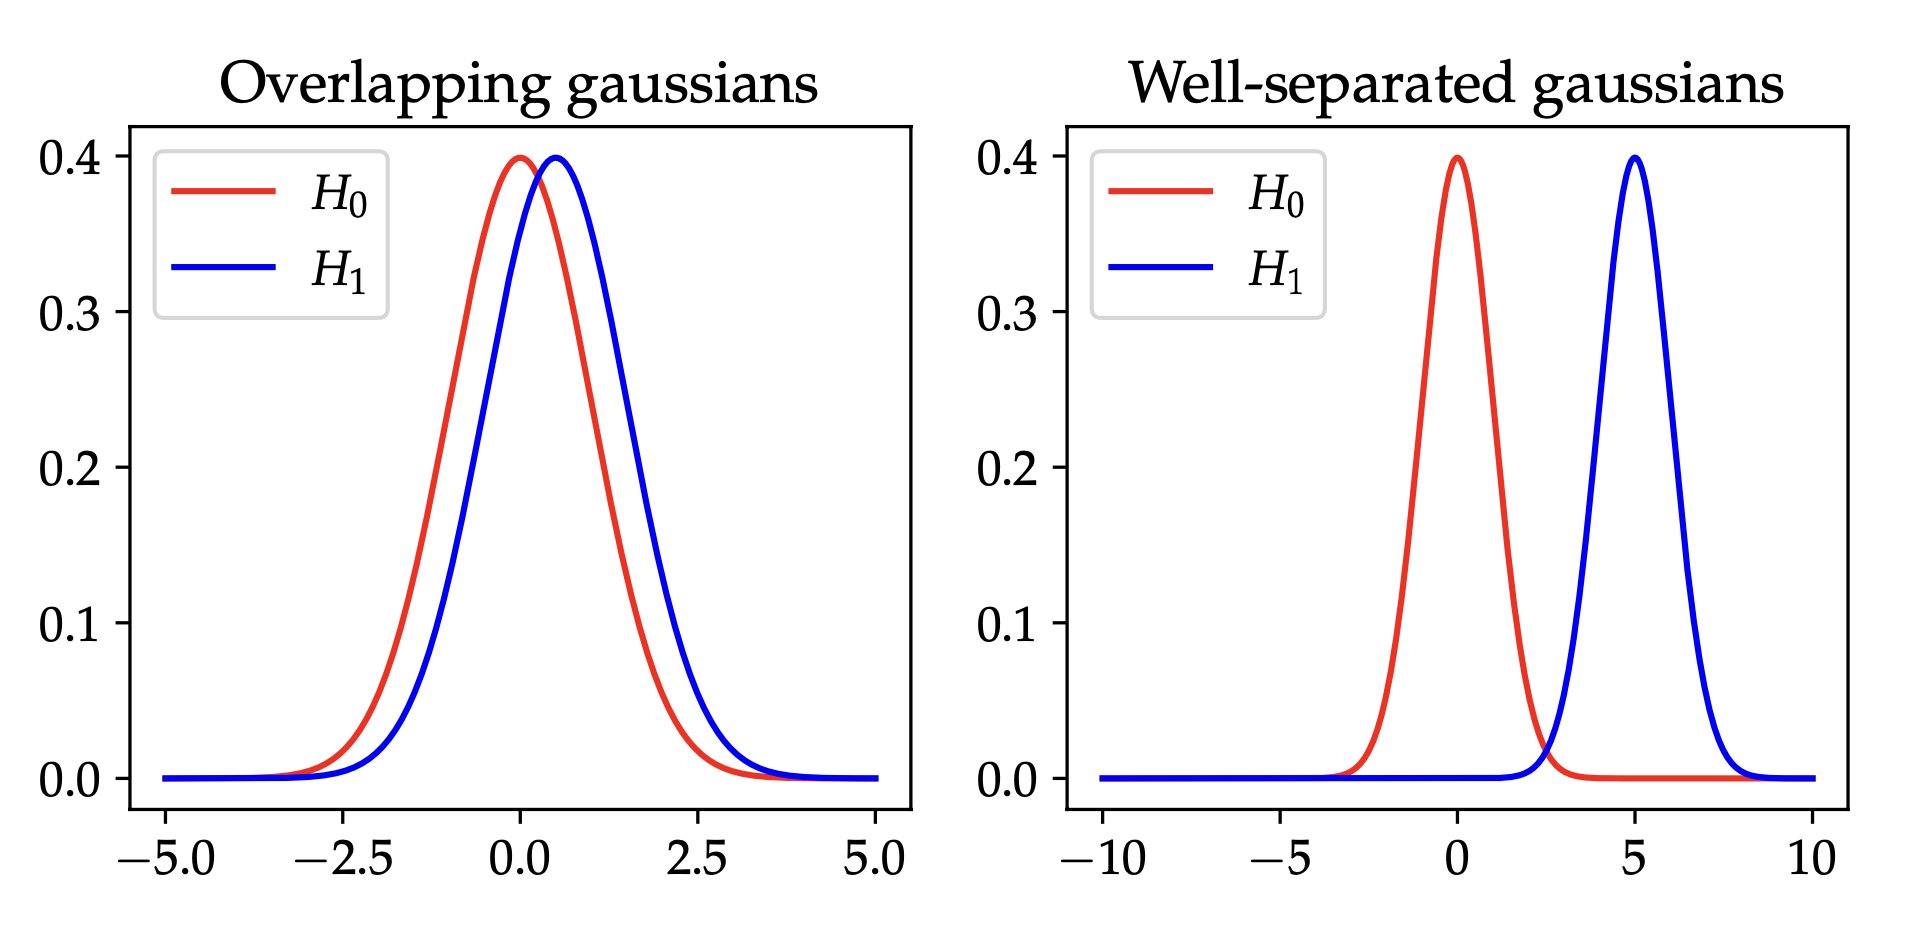

In [1]:
from IPython.display import Image, display
display(Image(filename='signal_and_noise.png'))

Consider the "Signal vs Noise" problem. 
In this problem, we have a input $x,$ and we want to find whether the input comes from the "noise" distribution
\begin{equation*}
p(X|Y = 0) = \mathcal{N}(0, 1) \quad (1)
\end{equation*}
or "signal" distribution
\begin{equation*}
p(X|Y = 1) = \mathcal{N}(s, 1) \quad (2),
\end{equation*}
where $s \geq 0.$

In particular, we want to find a predictor $\widehat{Y}(x)$ such that minimizes
\begin{equation*}
E_{(x,y) \sim P(X,Y)}[loss(\widehat{Y}(x), y)].
\end{equation*}

For simplicity, we assume that $loss(0, 0) = loss(1, 1) = 0$ and $loss(0, 1) = loss(1, 0) = 1.$ 

Then, we know that an optimal predictor is
\begin{equation*}
\widehat{Y}(x) = \arg\max_{y \in \{0, 1\}} P(Y = y | X = x).
\end{equation*}
This is the maximum a posteriori (MAP) rule.

#### Equal priors
Consider the case when $P(Y = 1) = P(Y = 0).$
Thus 
\begin{equation*}
\widehat{Y}(x) = \arg\max_{y \in \{0, 1\}} P(Y = y | X = x) = \arg\max_{y \in \{0, 1\}} p(X = x | Y = y). \quad (3)
\end{equation*}

Using (1) and (2), we can compute (3).

Furthermore, note that if $X \sim \mathcal{N}(\mu, \sigma)$
\begin{equation*}
p(X = x) = \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(\frac{-(x - \mu)^2}{2 \sigma^2}\right) \quad (4)
\end{equation*}

#### Implement Normal Distribution

- assmue $x$ is a scalar

In [2]:
import math

def pdf_normal(x, mu, sigma):
    const_norm = 1 / (math.sqrt(2 * math.pi) * sigma)
    exponent = math.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
    return const_norm * exponent


assert abs(pdf_normal(x=2, mu=0, sigma=1) - 0.053) < 0.01

- $x$ is a numpy array, i.e., $x\in \mathbb{R}^d$

In [3]:
import numpy as np

def pdf_normal(x, mu, sigma):
    const_norm = 1 / (math.sqrt(2 * math.pi) * sigma)
    exponent = np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
    return const_norm * exponent

np.testing.assert_almost_equal(pdf_normal(x=np.array([0, 2, -2]), mu=0, sigma=1), 
                               [0.398, 0.053, 0.053], decimal=2)

We are ready to classify our input. Assume that the parameter $s = 10.$ And we observe $6, 0, 4.5, 10.$

**Question**: Using (3), what shall be a label for each observation?

In [4]:
x = np.array([6, 0, 4.5, 10])
s = 10

# Task: Implement the rule in (3)
def predictor(x):
    prob_y_0 = pdf_normal(x, 0, 1)
    prob_y_1 = pdf_normal(x, s, 1)
    return (prob_y_1 > prob_y_0).astype(np.int32)

predictions = predictor(x) 
print(f"Predictions {x}: {predictions}")

Predictions [ 6.   0.   4.5 10. ]: [1 0 0 1]


It means that values $0$ and $4.5$ are more likely to be generated by the process from $Y=0$ (which we refer to as noise) according to our predictor $\widehat{Y}(x)$ in (3).

Now let us test the input $x = 100$:

In [9]:
x = np.array(100)
prediction = predictor(x)
print(f"Prediction {x}: {prediction}")

Prediction 100: 1


**Something seems to be wrong here...** 

We know that $6$ and $10$ are not noises. How is it possible that $100$ is a noise? (**Stop here and think about it.**)

---

Let's check the probabilities:

In [6]:
print(pdf_normal(x, 0, 1))
print(pdf_normal(x, s, 1))

0.0
0.0


They are both so small that they are numerically equal to zero. 

Can we do something about it? 

Note that we are using the probabilities to make a decision. However, we can use any increasing function of the probabilities to make a decision. Therefore, we can use more numerically stable log-probabilities to make a decision. Thus, we can use the following predictor

\begin{equation*}
\widehat{Y}(x) = \arg\min_{y \in \{0, 1\}} p(X = x | Y = y) = \arg\min_{y \in \{0, 1\}} \log p(X = x | Y = y)
\end{equation*}

In [8]:
# TASK: Implement the log of (4)
def log_pdf_normal(x, mu, sigma):
    const_norm = 1 / (math.sqrt(2 * math.pi) * sigma)
    exponent = -(x - mu) ** 2 / (2 * sigma ** 2)
    return np.log(const_norm) + exponent

def predictor(x):
    prob_y_0 = log_pdf_normal(x, 0, 1)
    prob_y_1 = log_pdf_normal(x, s, 1)
    return (prob_y_1 > prob_y_0).astype(np.int32)

x = np.array([6, 0, 4.5, 10, 100])
predictions = predictor(x) 
print(f"Predictions {x}: {predictions}")

Predictions [  6.    0.    4.5  10.  100. ]: [1 0 0 1 1]


Now the answers are meaningful.

Let's look at log_pdf_normal:

In [8]:
x = 100
print(pdf_normal(x, 0, 1))
print(pdf_normal(x, s, 1))
print(log_pdf_normal(x, 0, 1))
print(log_pdf_normal(x, s, 1))

0.0
0.0
-5000.918938533205
-4050.9189385332047


#### Different priors: 

$$P(Y = 1) \neq P(Y = 0)$$

Assume that $P(Y=1) = 0.999$ and $P(Y=0) = 0.001.$ It means that the noises are quite rare. 

**Task**: Implement new predictor $\widehat{Y}(x)$ reflecting this change.

In [10]:
p_0 = 0.001
p_1 = 0.999

# TASK: Implement a new predictor
def predictor(x):
    prob_y_0 = log_pdf_normal(x, 0, 1) + np.log(p_0)
    prob_y_1 = log_pdf_normal(x, s, 1) + np.log(p_1)
    return (prob_y_1 > prob_y_0).astype(np.int32)

x = np.array([6, 0, 4.5, 10, 100])
predictions = predictor(x) 
print(f"Predictions {x}: {predictions}")

Predictions [  6.    0.    4.5  10.  100. ]: [1 0 1 1 1]


Note that even $4.5$ is now classified as a signal now. Why is this the case? 